In [1]:
import keras
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Dense, Activation
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.models import Model
from keras.applications import imagenet_utils
from keras.layers import Dense, GlobalAveragePooling2D, Conv2D
from keras.applications import MobileNet
from keras.applications.mobilenet import preprocess_input
import numpy as np
from IPython.display import Image
import cv2
import os
import matplotlib.pyplot as plt
from keras import layers
from keras.layers import Input
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Add
from keras.layers import Dot
from keras.layers import Permute
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Conv2D
from keras.layers import Lambda
from keras.layers import Reshape
from keras.layers import DepthwiseConv2D
from keras.layers import ZeroPadding2D
from keras.layers import AveragePooling2D
from keras.layers import Embedding
from keras.engine import Layer
from keras.engine import InputSpec
from keras.engine.topology import get_source_inputs
from keras import backend as K
from keras.applications import imagenet_utils
from keras.utils import conv_utils
from keras.utils.data_utils import get_file
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

import pickle as pkl

Using TensorFlow backend.


Image size:(360, 480, 3)
Annotations size:(360, 480)


(-0.5, 479.5, 359.5, -0.5)

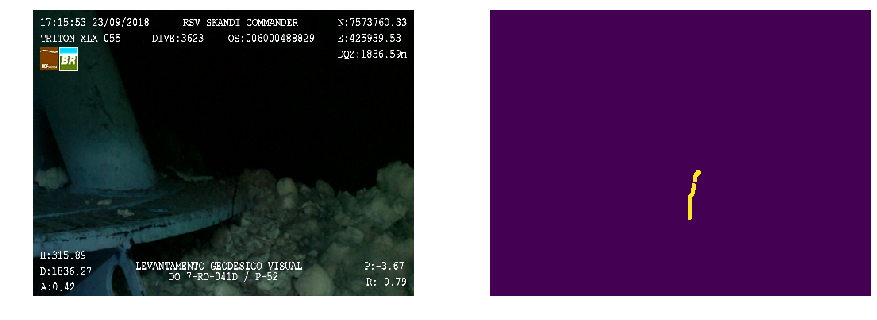

In [2]:
image_file = 'data/VAZAMENTO/data_1/images/20.png'
anot_file = 'data/VAZAMENTO/data_1/annotations/20.png'
W,H=480,360
img = cv2.imread(image_file)
img = cv2.resize(img, (W,H))
anot = cv2.imread(anot_file)
anot = cv2.resize(anot, (W,H))[:,:,2]>0

print('Image size:{}'.format(img.shape))
print('Annotations size:{}'.format(anot.shape))
plt.figure(figsize=(15,8))
plt.subplot(121)
plt.imshow(img)
plt.axis('off')
plt.subplot(122)
plt.imshow(anot)
plt.axis('off')

# Load mobilenet model

# Memory Encoder

In [3]:
from keras.engine import Layer
class BilinearUpsampling(Layer):
    """Just a simple bilinear upsampling layer. Works only with TF.
       Args:
           upsampling: tuple of 2 numbers > 0. The upsampling ratio for h and w
           output_size: used instead of upsampling arg if passed!
    """

    def __init__(self, upsampling=(2, 2), output_size=None, data_format=None, **kwargs):

        super(BilinearUpsampling, self).__init__(**kwargs)

        self.data_format = K.normalize_data_format(data_format)
        #self.data_format = conv_utils.normalize_data_format(data_format)
        self.input_spec = InputSpec(ndim=4)
        if output_size:
            self.output_size = conv_utils.normalize_tuple(
                output_size, 2, 'output_size')
            self.upsampling = None
        else:
            self.output_size = None
            self.upsampling = conv_utils.normalize_tuple(
                upsampling, 2, 'upsampling')

    def compute_output_shape(self, input_shape):
        if self.upsampling:
            height = self.upsampling[0] * \
                input_shape[1] if input_shape[1] is not None else None
            width = self.upsampling[1] * \
                input_shape[2] if input_shape[2] is not None else None
        else:
            height = self.output_size[0]
            width = self.output_size[1]
        return (input_shape[0],
                height,
                width,
                input_shape[3])

    def call(self, inputs):
        if self.upsampling:
            return K.tf.image.resize_bilinear(inputs, (inputs.shape[1] * self.upsampling[0],
                                                       inputs.shape[2] * self.upsampling[1]),
                                              align_corners=True)
        else:
            return K.tf.image.resize_bilinear(inputs, (self.output_size[0],
                                                       self.output_size[1]),
                                              align_corners=True)

    def get_config(self):
        config = {'upsampling': self.upsampling,
                  'output_size': self.output_size,
                  'data_format': self.data_format}
        base_config = super(BilinearUpsampling, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [4]:
W , H = 480 , 360
W_ENC , H_ENC = 60, 45
numClasses = 3 #91 #3
embedding_size = 32
dimensionEmbeddingClass = 3 #embedding_size + RGB


#Utilizando Embedding
#m_mask = Input(shape=(3,H,W))
#m_mask_embedding = Embedding(3, embedding_size)(m_mask)
#m_image = Input(shape=(3,H,W,3))
#m_input_tensor = Concatenate(axis=-1)([m_mask_embedding,m_image])

#Sem Embedding
m_input_tensor = Input(shape=(3,H,W,4))

m_input_tensor_2 = Lambda(lambda x: x[:,:,:,:,:3])(m_input_tensor)

x = Lambda(lambda x: K.tf.reshape(x, [-1, H, W, dimensionEmbeddingClass]))(m_input_tensor_2)
mobile_M = keras.applications.mobilenet_v2.MobileNetV2(input_tensor=x, weights=None)
m = mobile_M.layers[36].output
m_key = Conv2D(128, 1, name='m_key')(m)
m_key = Lambda(lambda x: K.tf.reshape(x, [-1, 3, H_ENC, W_ENC, 128]))(m_key)
m_value = Conv2D(512, 1, name='m_value')(m)
m_value = Lambda(lambda x: K.tf.reshape(x, [-1, 3, H_ENC, W_ENC, 512]))(m_value)
memory_model = Model(inputs=mobile_M.input, outputs=[m_key , m_value], name='memory')

q_input_tensor = Input(shape=(H, W, 3))
x = Lambda(lambda x: K.tf.reshape(x, [-1, H, W, 3]))(q_input_tensor)
mobile_Q =  keras.applications.mobilenet.MobileNet(input_tensor=x, weights=None)
q = mobile_Q.layers[36].output
q_key = Conv2D(128, 1, name='q_key')(q) 
q_value = Conv2D(512, 1, name='q_value')(q)
query_model = Model(inputs=mobile_Q.input, outputs=[q_key , q_value], name='query')

for l in memory_model.layers:
    memory_model.get_layer(name=l.name).name='memory_'+l.name
for l in query_model.layers:
    query_model.get_layer(name=l.name).name='query_'+l.name
    
k_m = Reshape([-1,128])(memory_model.output[0])
k_q = Reshape([-1,128])(query_model.output[0])
memory = Dot(2)([k_q,k_m])
memory = Activation('softmax')(memory)

v_m = Reshape([-1,512])(memory_model.output[1])
v_m = Permute((2,1))(v_m)
read = Dot(2)([memory,v_m])
read = Reshape([H_ENC,W_ENC,512])(read)

x = Concatenate(3)([read,query_model.output[1]])
last_layer_name = 'custom_logits_semantic'

# Decoder

x = Conv2D(numClasses, (1, 1), padding='same', name=last_layer_name)(x) #mudar num de classes
y = BilinearUpsampling(output_size=(H, W))(x)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [5]:
#model = Model(inputs=mobile_M.inputs+[mobile_Q.input], outputs=y) 
model = Model(inputs=[mobile_M.input , mobile_Q.input], outputs=y) 
model.input

[<tf.Tensor 'input_1:0' shape=(?, 3, 360, 480, 4) dtype=float32>,
 <tf.Tensor 'input_2:0' shape=(?, 360, 480, 3) dtype=float32>]

In [6]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
memory_input_1 (InputLayer)     (None, 3, 360, 480,  0                                            
__________________________________________________________________________________________________
query_input_2 (InputLayer)      (None, 360, 480, 3)  0                                            
__________________________________________________________________________________________________
memory_lambda_1 (Lambda)        (None, 3, 360, 480,  0           memory_input_1[0][0]             
__________________________________________________________________________________________________
query_lambda_5 (Lambda)         (None, 360, 480, 3)  0           query_input_2[0][0]              
__________________________________________________________________________________________________
memory_lam

In [7]:
def process_instance(m1 , m2 , m3 ,q, c):
    memory_seq_input=[]
    for m in [m1 , m2 , m3]:
        memory_images_file , memory_annot_file = m
        m_img = cv2.imread(memory_images_file)
        m_img = cv2.resize(m_img, (W,H))/255

        m_annot = cv2.imread(memory_annot_file)
        m_annot = cv2.resize(m_annot, (W,H))[:,:,2:3]>0

        mem_elem_input = np.concatenate([m_img, m_annot],axis=2)
        memory_seq_input.append(mem_elem_input)
    memory_input = np.stack(memory_seq_input)

    # Query
    query_img_file , query_annot_file = q
    query_img = cv2.imread(query_img_file)
    query_img = cv2.resize(query_img, (W,H))/255

    query_annot = cv2.imread(query_annot_file) #* #saida com num de classes
    query_annot = cv2.resize(query_annot, (W,H))[:,:,2:3]>0
    query_annot = query_annot * c

    return np.expand_dims(memory_input,axis=0) , np.expand_dims(query_img,axis=0), np.expand_dims(query_annot,axis=0)

In [8]:
import os
import glob

directory = 'data/DAVIS/JPEGImages/480p'
folders = [x[0] for x in os.walk(directory)][1:]


In [9]:
#usando TFRecord

# Inicializa variáveis TFRecord

from TFRecord_DataAug_SEM_embedding import *


# - Executar

READING_BUFFER_SIZE=500
BATCH_SIZE=2
ITERACOES= 1 #int(6000/BATCH_SIZE)

#NewData_shuffled_All_shuffle.tfrecord

# ler dataset
#dataset_train=get_dataset('davis_3_shuffled.tfrecord',READING_BUFFER_SIZE,BATCH_SIZE)
dataset_train=get_dataset('oleo_gas_withoutvalidation_32b_small_w_smoke.tfrecord',READING_BUFFER_SIZE,BATCH_SIZE)
#dataset_train=get_dataset('DataRicardo_shuffled.tfrecord',READING_BUFFER_SIZE,BATCH_SIZE)
#dataset_train=get_dataset('DataRicardo.tfrecord',READING_BUFFER_SIZE,BATCH_SIZE)

# iterador - criar
iterator = tf.data.Iterator.from_structure(dataset_train.output_types,
                                         dataset_train.output_shapes)
#inicializar gerador
next_element = iterator.get_next()

#initialize iteratores (TRAIN)
training_init_op = iterator.make_initializer(dataset_train)

# train



For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use `tf.data.experimental.parallel_interleave(...)`.
Instructions for updating:
Use `tf.data.experimental.map_and_batch(...)`.
 --- DATA AUGMENTATION --- Rotation random(graus max): 20
Pad and Crop(pad_resize): 1.2
Britghtness(max): 0.3
FlipHorizontal
Zoom and Crop(max zoom): 1.5


In [10]:
#Generator sem Embedding
def get_generator_TFRecord(sess):  
    sess.run(training_init_op)
    while True:         
        image_data = sess.run(next_element)
        m_in = image_data[0]
        q_in = image_data[1]
        q_an_oh = image_data[2]        
        yield [m_in, q_in], q_an_oh



sess = K.get_session()

g = get_generator_TFRecord(sess)

a, b= g.__next__()


from tqdm import tqdm

n = 1115//2
for _ in range(n):
    a,b = g.__next__()
    print(a[0].shape)
    print(a[1].shape)
    print(b.shape)

In [11]:
optimizer = keras.optimizers.Adam(lr=0.0005)

In [12]:
sess = K.get_session()
#sess = tf.Session()
generator = get_generator_TFRecord(sess)

In [13]:
def binary_crossentropy_with_logits(ground_truth, predictions):
    return K.mean(K.binary_crossentropy(ground_truth, predictions,from_logits=True),axis=-1)
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = K.tf.to_int32(y_pred > t)
        score, up_opt = K.tf.metrics.mean_iou(y_true, y_pred_, numClasses)
        #config = tf.ConfigProto()
        #config.gpu_options.per_process_gpu_memory_fraction = 0.8
        #set_session(tf.Session(config=config))
        K.get_session().run(K.tf.local_variables_initializer())
        with K.tf.control_dependencies([up_opt]):
            score = K.tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

In [14]:
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.compile(optimizer='adam', loss=binary_crossentropy_with_logits,metrics=['accuracy',mean_iou])

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


# Query Embedding

model.outputs

N_EPOCHS = 200
batch_size = 2
#STEPS = 5938//batch_size #len(dataset)//batch_size # dataset DAVIS
#2232
STEPS = 677//batch_size # dataset NewData


models_path = 'models'
model_name = "model_embbeding_without_val_without_embbeding_sem_mask_7_buz_w_smoke" + str(N_EPOCHS) + ".model"
model_name = os.path.join(models_path, model_name)

earlyStopping = EarlyStopping(monitor='loss', mode = 'min',patience=20, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='loss', mode = 'min',factor=0.5, patience=4, min_lr=0.0000001, verbose=1)
model_checkpoint = ModelCheckpoint(model_name,monitor='loss',mode = 'min', save_best_only=True, verbose=1, period=1)

history = model.fit_generator(generator, epochs=N_EPOCHS, steps_per_epoch=STEPS, callbacks=[model_checkpoint,earlyStopping,reduce_lr])
#model.fit(generator, epochs=N_EPOCHS, steps_per_epoch=STEPS, callbacks=[model_checkpoint,earlyStopping,reduce_lr])

import pickle
output = open('h_davis_14_Embedding.pkl', 'wb')
pickle.dump(history, output)
output.close()

# Inferência

In [15]:
N_EPOCHS = 200

#numClasses = 3 #91
#W , H = 480 , 360
#W_ENC , H_ENC = 60, 45
#m_input_tensor = Input(shape=(3,H,W,4))
#x = Lambda(lambda x: K.tf.reshape(x, [-1, H, W, 4]))(m_input_tensor)
#mobile_M = keras.applications.mobilenet_v2.MobileNetV2(input_tensor=x, weights=None)
#
#
#q_input_tensor = Input(shape=(H, W, 3))
#x = Lambda(lambda x: K.tf.reshape(x, [-1, H, W, 3]))(q_input_tensor)
#mobile_Q =  keras.applications.mobilenet.MobileNet(input_tensor=x, weights=None)
#
#y = BilinearUpsampling(output_size=(H, W))(x)

# ----------------------

#model_Tfrecord_NewData_all

models_path = 'models'
model_name = "model_embbeding_without_val_without_embbeding_sem_mask_7_buz_w_smoke" + str(N_EPOCHS) + ".model"
#model_name = "model_Tfrecord_davis_14_sem_Embedding_" + str(N_EPOCHS) + ".model"
model_name = os.path.join(models_path, model_name)


#loaded_model = Model(inputs=mobile_M.inputs+[mobile_Q.input], outputs=y) 
loaded_model = Model(inputs=[mobile_M.input , mobile_Q.input], outputs=y) 
loaded_model.compile(optimizer='adam', loss=binary_crossentropy_with_logits,metrics=['accuracy',mean_iou])
loaded_model.load_weights(model_name)
loaded_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
memory_input_1 (InputLayer)     (None, 3, 360, 480,  0                                            
__________________________________________________________________________________________________
query_input_2 (InputLayer)      (None, 360, 480, 3)  0                                            
__________________________________________________________________________________________________
memory_lambda_1 (Lambda)        (None, 3, 360, 480,  0           memory_input_1[0][0]             
__________________________________________________________________________________________________
query_lambda_5 (Lambda)         (None, 360, 480, 3)  0           query_input_2[0][0]              
__________________________________________________________________________________________________
memory_lam

In [16]:
import numpy as np
import pydensecrf.densecrf as dcrf
from skimage.io import imread, imsave
from pydensecrf.utils import unary_from_labels, create_pairwise_bilateral, create_pairwise_gaussian
from skimage.color import gray2rgb
from skimage.color import rgb2gray
import matplotlib.pyplot as plt


def crf(original_image, annotated_image, use_2d = True):
    
    # Converting annotated image to RGB if it is Gray scale
    if(len(annotated_image.shape)<3):
        annotated_image = gray2rgb(annotated_image)
    
    #imsave("testing2.png",annotated_image)
        
    #Converting the annotations RGB color to single 32 bit integer
    annotated_label = annotated_image[:,:,0] + (annotated_image[:,:,1]<<8) + (annotated_image[:,:,2]<<16)
    
    # Convert the 32bit integer color to 0,1, 2, ... labels.
    colors, labels = np.unique(annotated_image[:,:,0], return_inverse=True)
    
    #Creating a mapping back to 32 bit colors
    colorize = np.empty((len(colors), 3), np.uint8)
    colorize[:,0] = (colors & 0x0000FF)
    colorize[:,1] = (colors & 0x00FF00) >> 8
    colorize[:,2] = (colors & 0xFF0000) >> 16
    
    #Gives no of class labels in the annotated image
    n_labels = len(set(labels.flat)) 
    
    print("No of labels in the Image are ")
    print(n_labels)
    
    
    #Setting up the CRF model
    if use_2d :
        d = dcrf.DenseCRF2D(original_image.shape[1], original_image.shape[0], n_labels)

        # get unary potentials (neg log probability)
        U = unary_from_labels(labels, n_labels, gt_prob=0.99, zero_unsure=False)
        d.setUnaryEnergy(U)

        # This adds the color-independent term, features are the locations only.
        d.addPairwiseGaussian(sxy=(3, 3), compat=3, kernel=dcrf.DIAG_KERNEL,
                          normalization=dcrf.NORMALIZE_SYMMETRIC)

        # This adds the color-dependent term, i.e. features are (x,y,r,g,b).
        d.addPairwiseBilateral(sxy=(80,80), srgb=(13,13,13), rgbim=(original_image*255).astype(np.uint8),
                           compat=10,
                           kernel=dcrf.DIAG_KERNEL,
                           normalization=dcrf.NORMALIZE_SYMMETRIC)
        
    #Run Inference for 5 steps 
    Q = d.inference(50)

    # Find out the most probable class for each pixel.
    MAP = np.argmax(Q, axis=0)

    # Convert the MAP (labels) back to the corresponding colors and save the image.
    # Note that there is no "unknown" here anymore, no matter what we had at first.
    MAP = colorize[MAP,:]
    #imsave(output_image,MAP.reshape(original_image.shape))
    return MAP.reshape(original_image.shape),Q

In [26]:
def getPredictionInformation(predImage, probImage, mask, nPixels):
    """Returns the obtained information for probabilities and density"""
    probabilities = np.sum(probImage*mask)
    positive = np.sum(mask)
    # Review this function
    if positive > 0:
        probabilities /= positive
    else:
        probabilities = 0

    # Get pixel density from predicted 
    density = float(np.sum(predImage))        
    # Calculate density for positive predictions
    positiveDensity = density/nPixels
    return probabilities, positiveDensity

In [27]:
W , H = 480 , 360

#Sem Enbedding

    
def process_instance_inference(m_zip,query_img):
    
    memory_seq_input=[]
    for m_img, m_annot in m_zip: 
        
        m_img = cv2.resize(m_img, (W,H))#/255  
        
        m_annot = cv2.resize(m_annot, (W,H)) 
        
        m_annot = np.reshape(m_annot, (H,W,1)) #1  
                
        mem_elem_input = np.concatenate([m_img, m_annot],axis=2)
        memory_seq_input.append(mem_elem_input)
    memory_input = np.stack(memory_seq_input)

    # Query
    query_img = cv2.resize(query_img, (W,H))#/255
    #print(memory_input.shape, query_img.shape)

    return np.expand_dims(memory_input,axis=0) , np.expand_dims(query_img,axis=0)

def run_inference_video(video_path, output_video_path, classes, video_filename):
    
    outputPathP = "videos/inference/"+video_filename.split('.')[0]+'.p'
    
    THRESHOLD = 0.5
    W , H = 480 , 360
    totalPixels = W*H
    
    Probability = []
    Density = []
    
    
    
    debug = False
    
    cap = cv2.VideoCapture(video_path)
    n_frame = 0

    # Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output_writer = cv2.VideoWriter(output_video_path, fourcc, 10, (2*W, H))

    m_annot1 = np.zeros((H,W,1), np.uint8)
    m_annot2 = np.zeros_like(m_annot1)
    m_annot3 = np.zeros_like(m_annot2)
    
    res,_ = cap.read()
    while not res:
        res, image = cap.read()
        print('trying...{}'.format(n_frame))
        n_frame += 1
    
    while cap.isOpened():
        cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame)
        ret_m1, m_frame1 = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame+1)
        ret_m2, m_frame2 = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame+2)
        ret_m3, m_frame3 = cap.read()
        cap.set(cv2.CAP_PROP_POS_FRAMES, n_frame+3)
        ret_q, q_frame = cap.read()        
        m_frame1 = m_frame1[:,:,::-1]
        m_frame2 = m_frame2[:,:,::-1]
        m_frame3 = m_frame3[:,:,::-1]
        
        
        if ret_m1 and ret_m2 and ret_m3 and ret_q:
            
            tempP,tempD = [], []
            
            if debug:
                plt.figure(figsize=(15,8))
            
            m_in , q_in = process_instance_inference(zip([m_frame1 , m_frame2 , m_frame3], [m_annot1, m_annot2, m_annot3]), q_frame)
                        
            m_in = np.vstack(m_in)
            q_in = np.vstack(q_in)

            m_in = np.expand_dims(m_in, axis=0)
            q_in = np.expand_dims(q_in, axis=0)
            
            q_in[0] = cv2.cvtColor(q_in[0], cv2.COLOR_BGR2RGB)

            # Prediction
            q_output = loaded_model.predict([m_in, q_in]) 
            
            if debug:
                plt.subplot(151)
                plt.imshow(q_in[0])
                plt.axis('off')

                plt.subplot(152)
                plt.imshow(np.argmax(q_output[0],axis = -1))
                plt.axis('off')
                      
            
            
            prob_img = np.reshape(q_output[0,:,:,:], [1,H,W,classes]) #NUMERO DE CLASSES
            pred = np.reshape(np.argmax(prob_img,axis = -1),[H,W]) # 360 x 480      
            
            
            if debug:
                plt.subplot(153)
                plt.imshow(pred)
                plt.axis('off')
            
            #kernel = np.ones((3,3),np.uint8)
            #pred = cv2.erode(pred.astype(np.uint8),kernel,iterations = 2)
            kernel = np.ones((3,3),np.uint8)
            pred = cv2.dilate(pred.astype(np.uint8),kernel,iterations = 2)
            
            

            q_output = np.reshape(np.argmax(prob_img,axis = -1),[H,W,1]) #ORIGINAL
            
            #print(q_output.shape) #(360, 480, 1)
            
            #salvando probabilities, density --------------------
            img = q_output
            j=0#for j in range(1,classes):
            probImg = np.squeeze(img[:,:,j])
            predicted = np.squeeze(np.argmax(img, axis=2)).astype('float')
            mask = np.squeeze((probImg>THRESHOLD)).astype('float')
            probabilities, density = getPredictionInformation(predicted, probImg, mask, totalPixels)
            tempP.append(probabilities)
            tempD.append(density)
            Probability.append(tempP)
            Density.append(tempD)
            #------------------------------------------------------------
            
            
            #kernel = np.ones((100,100),np.uint8)
            #q_output = np.reshape(np.argmax(prob_img,axis = -1),[H,W])
            #q_output = cv2.dilate(q_output.astype(np.uint8), kernel, iterations = 2)
            #q_output = np.reshape(q_output.astype(np.uint8),[H,W,1])
            #q_output = (np.reshape(prob_img[:,:,:,1],[H,W])>0.5).astype("float32")
            

            q_output_rgb = np.zeros((H,W,3), np.float)
            q_output_rgb[:,:,2] = pred
            

            q_frame = cv2.resize(q_frame, (W,H))
            #q_frame = cv2.cvtColor(q_frame, cv2.COLOR_BGR2RGB)
            
            if debug:
                plt.subplot(154)
                plt.imshow(q_frame)
                plt.axis('off')

            overlayed = cv2.addWeighted(q_frame.astype(np.float), 0.6, q_output_rgb*255, 0.4, 2)
            
            
            if debug:
                plt.subplot(155)
                plt.imshow(q_output_rgb*255)
                plt.axis('off')
            
            #q_frame = cv2.cvtColor(q_frame, cv2.COLOR_BGR2RGB)
            
            finalimage = np.concatenate((q_frame, overlayed), axis=1)
            
             
            output_writer.write(finalimage.astype(np.uint8))

            n_frame += 1
            m_annot1 = m_annot2
            m_annot2 = m_annot3
            m_annot3 = q_output
            
            if(debug and n_frame > 10):
                break
            
        else:
            break

    cap.release()
    output_writer.release()
    print("salvando...")
    Probability = np.asarray(Probability)
    Density = np.asarray(Density)
    historicData = (Density , Probability, "none")
    pkl.dump(historicData, open(outputPathP, 'wb'))
    print("OK!!!")

In [28]:
#### FAZ INFERÊNCIA NOS VÍDEOS


import os


video_folder = 'videos'
video_filename = 'video_cut_4.mp4'
#video_folder = 'videos/vazamento'
#video_filename = '1a -Desafio.mpg'
#video_filename = '2 - Negativo_com_positivo_Esporadico.mpg'
#video_filename = '2 - Positivo.mpg'
inference_folder = 'inference'

video_path =  os.path.join(video_folder, video_filename)
video_basename = os.path.splitext(os.path.basename(video_filename))[0]
#video_extension = os.path.splitext(os.path.basename(video_filename))[1]

if not os.path.exists(os.path.join(video_folder, inference_folder)):
    os.mkdir(os.path.join(video_folder, inference_folder))
    
output_video_path = os.path.join(video_folder, inference_folder, video_basename+'_prediction.mp4')
#print(video_path, output_video_path)
run_inference_video(video_path, output_video_path, 3, video_filename)

salvando...
OK!!!


In [ ]:
W , H = 480 , 360

#Sem Enbedding
### PEGANDO DAS IMAGENS

    
def process_instance_inference(m_zip,query_img):
    
    memory_seq_input=[]
    for m_img, m_annot in m_zip: 
        
        m_img = cv2.resize(m_img, (W,H))#/255  
        
        m_annot = cv2.resize(m_annot, (W,H)) 
        
        m_annot = np.reshape(m_annot, (H,W,1)) #1  
                
        mem_elem_input = np.concatenate([m_img, m_annot],axis=2)
        memory_seq_input.append(mem_elem_input)
    memory_input = np.stack(memory_seq_input)

    # Query
    query_img = cv2.resize(query_img, (W,H))#/255
    #print(memory_input.shape, query_img.shape)

    return np.expand_dims(memory_input,axis=0) , np.expand_dims(query_img,axis=0)

def run_inference_video(video_path, output_video_path):
    
    debug = False
    n_frame = 0

    # Video Writer
    fourcc = cv2.VideoWriter_fourcc(*'DIVX')
    output_writer = cv2.VideoWriter(output_video_path, fourcc, 10, (2*W, H))

    m_annot1 = np.zeros((H,W,1), np.uint8)
    m_annot2 = np.zeros_like(m_annot1)
    m_annot3 = np.zeros_like(m_annot2)
    
    
    
    directory = 'data/DAVIS_3/JPEGImages/480p/walking/'
    counting = -1
    END = False
    while not END:
        counting +=1
        inputName = str(counting).zfill(5)
        pathName = directory+inputName+".jpg"
        m_frame1 = cv2.imread(pathName)
        
        counting +=1
        inputName = str(counting).zfill(5)
        pathName = directory+inputName+".jpg"
        m_frame2 = cv2.imread(pathName)
        
        counting +=1
        inputName = str(counting).zfill(5)
        pathName = directory+inputName+".jpg"
        m_frame3 = cv2.imread(pathName)
        
        counting +=1
        inputName = str(counting).zfill(5)
        pathName = directory+inputName+".jpg"
        q_frame = cv2.imread(pathName)
        
        m_frame1 = m_frame1[:,:,::-1]
        m_frame2 = m_frame2[:,:,::-1]
        m_frame3 = m_frame3[:,:,::-1]
        
        print(counting)
        if counting == 95:
            END = True
        
        
        #if ret_m1 and ret_m2 and ret_m3 and ret_q:
            
        if debug:
            plt.figure(figsize=(15,8))

        m_in , q_in = process_instance_inference(zip([m_frame1 , m_frame2 , m_frame3], [m_annot1, m_annot2, m_annot3]), q_frame)

        m_in = np.vstack(m_in)
        q_in = np.vstack(q_in)

        m_in = np.expand_dims(m_in, axis=0)
        q_in = np.expand_dims(q_in, axis=0)

        q_in[0] = cv2.cvtColor(q_in[0], cv2.COLOR_BGR2RGB)

        # Prediction
        q_output = loaded_model.predict([m_in, q_in]) 
        

        if debug:
            plt.subplot(151)
            plt.imshow(q_in[0])
            plt.axis('off')

            plt.subplot(152)
            plt.imshow(np.argmax(q_output[0],axis = -1))
            plt.axis('off')


        #print(q_output[0,:,:,:].shape)
        prob_img = np.reshape(q_output[0,:,:,:], [1,H,W,5])
        
        pred = np.reshape(np.argmax(prob_img,axis = -1),[H,W]) # 360 x 480      


        if debug:
            plt.subplot(153)
            plt.imshow(pred)
            plt.axis('off')

        kernel = np.ones((3,3),np.uint8)
        pred = cv2.dilate(pred.astype(np.uint8),kernel,iterations = 2)     



        q_output = np.reshape(np.argmax(prob_img,axis = -1),[H,W,1]) #ORIGINAL

        q_output_rgb = np.zeros((H,W,3), np.float)
        q_output_rgb[:,:,2] = pred


        q_frame = cv2.resize(q_frame, (W,H))
        #q_frame = cv2.cvtColor(q_frame, cv2.COLOR_BGR2RGB)

        if debug:
            plt.subplot(154)
            plt.imshow(q_frame)
            plt.axis('off')

        overlayed = cv2.addWeighted(q_frame.astype(np.float), 0.6, q_output_rgb*255, 0.4, 0)


        if debug:
            plt.subplot(155)
            plt.imshow(q_output_rgb*255)
            plt.axis('off')
        q_frame = cv2.cvtColor(q_frame, cv2.COLOR_BGR2RGB)
        finalimage = np.concatenate((q_frame, overlayed), axis=1)


        output_writer.write(finalimage.astype(np.uint8))

        n_frame += 1
        m_annot1 = m_annot2
        m_annot2 = m_annot3
        m_annot3 = q_output

        if(debug and n_frame > 10):
            break
            
        #else:
            #break

    #cap.release()
    output_writer.release()    

In [ ]:
#### FAZ INFERÊNCIA NOS VÍDEOS


import os

video_folder = 'videos'
video_filename = '7-BUZ-31D-RJS_DVD2_2-1.mp4'
#video_folder = 'videos/vazamento'
#video_filename = '1a -Desafio.mpg'
#video_filename = '2 - Negativo_com_positivo_Esporadico.mpg'
#video_filename = '2 - Positivo.mpg'
inference_folder = 'inference'

video_path =  os.path.join(video_folder, video_filename)
video_basename = os.path.splitext(os.path.basename(video_filename))[0]
#video_extension = os.path.splitext(os.path.basename(video_filename))[1]

if not os.path.exists(os.path.join(video_folder, inference_folder)):
    os.mkdir(os.path.join(video_folder, inference_folder))
    
output_video_path = os.path.join(video_folder, inference_folder, video_basename+'_prediction.mp4')
#print(video_path, output_video_path)
run_inference_video(video_path, output_video_path)

# Sequence Inference

###### Get images

In [ ]:
sess = K.get_session()
g = get_generator_TFRecord(sess)

In [ ]:
a, b = g.__next__()

###### Do inference

In [ ]:
n_frame = 0


a, b = g.__next__()


#Sem Embedding
m_in = a[0][1:,:,:,:]
q_in = a[1][1:,:,:]

#Com Embedding
#m_in = a[0][:,:,:,:]
#q_in = a[1][:,:,:,:]
#q_in_2 = a[2][:,:,:,:]

q_frame = b[1]



# Prediction
q_output = loaded_model.predict([m_in, q_in])

#print(np.argmax(q_output[0],axis = -1).shape) #(1, 360, 480, 3)



W,H=480,360

#Sem Embedding
print('Image size:{}'.format(q_frame[:,:,0].shape))
plt.figure(figsize=(15,8))

plt.subplot(131)
plt.imshow(q_in[0])
plt.axis('off')

plt.subplot(132)
plt.imshow(np.argmax(q_frame,axis = -1))
plt.axis('off')

plt.subplot(133)
plt.imshow(np.argmax(q_output[0],axis = -1))
plt.axis('off')

cv2.imwrite('images_inference/finalimage_O_'+str(n_frame)+'.png',q_in[0])

cv2.imwrite('images_inference/finalimage_'+str(n_frame)+'.png',np.argmax(q_output[0],axis = -1))



In [ ]:
np.unique(q_output[:,:,0])

In [ ]:
c[1][0]

In [ ]:
a[0].dtype

In [ ]:
a[0][1,0,0,3]

In [ ]:
np.min(q_in)